<CENTER><h1>Emotion Detection</h1></center>

In [279]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T

from torchsummary import summary

import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam,SGD
from torch.nn.utils import weight_norm
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

### System Specification

We have started working with Colab Pro but encountered a lot of disconnection issues.<BR>
Therefore, we trained the model on our local GPU using Jupyter Lab.<BR>

In [58]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

# Project Introduction

## Problem Definition

The goal of this project is to develop a deep learning network that can accurately detect emotions from facial expressions in images.<BR>
The model should be able to recognize a range of emotions, including happiness, sadness, anger, fear, surprise, disgust, and neutrality.<BR>
We will take grayscale images in sizes of (48,48) and feed them into a CNN model to get prediction.

### Data

The model will be trained on a large dataset of labeled images, consisting of various human facial expressions displaying different emotions.<BR>
The dataset we used obtained from Kaggle's Emotion Detection database and consists of __28709__ images for train and __7178__ images for test.<BR>
There are __7__ classes in the dataset: __angry__, __disgusted__, __fearful__, __happy__, __neutral__, __sad__ and __surprised__.

### Approach

The project will involve the following steps:

1. <U>Data Import and Preprocessing</U>: We will use PyTorch Dataloaders to import and preprocess the images.

2. <U>Model architecture</U>: We will design and implement a deep learning convolutional neural network (CNN).

3. <U>Training and validation</U>: We then train the model on the preprocessed dataset, evaluate the model's performance, and tune the hyperparameters to optimize the model's accuracy.

4. <U>Testing and evaluation</U>: Next, we will test the model on a new dataset and evaluate its performance using accuracy metric.

5. <U>SOTA Architectures</U>: Finally, we will train state of the art architectures and study their performance.

### Benchmark

We will evaluate our model's performance by comparing to other projects made with the same dataset on Kaggle.<BR>
As we can see in the below links, the accuracies that reached in the leading models is around __65%__.<BR>
We aim to reach higher accuracies on validation and test datasets.
    
https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/code
    
Most voted #1: https://www.kaggle.com/code/odins0n/emotion-detection <BR>
Most voted #2: https://www.kaggle.com/code/aayushmishra1512/emotion-detector <BR>
Most voted #3: https://www.kaggle.com/code/sanya9/emotion-detection-using-alexnet <BR>
Most voted #4: https://www.kaggle.com/code/sonyd4d/cnn-for-emotion-detection

# Import Data

## Load data into PyTorch Dataloaders

In [119]:
BATCH_SIZE = 100

As we played with the batch size, we saw no significant changes in accuracies over time.<BR>
However, the training time changed and therefore we chose a batch size that gave us both convergence and reasonable training time.

In [189]:
path = 'data'

data_transforms = T.Compose([
                    T.Grayscale(num_output_channels=1),
                    T.ToTensor()])

train_data = datasets.ImageFolder(root= path+'/train', transform=data_transforms)
test_data = datasets.ImageFolder(root= path+'/test', transform=data_transforms)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

### Data Distribution

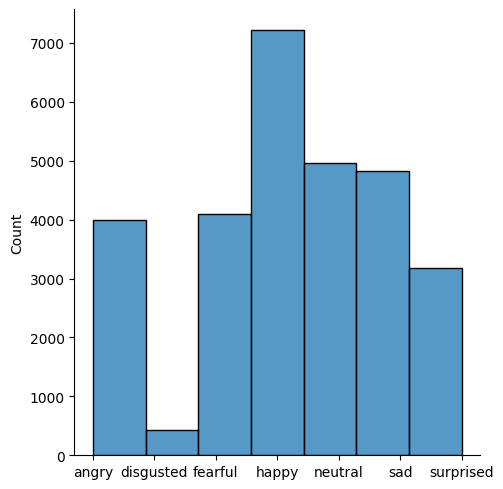

In [121]:
d = []
for batch in train_dataloader:
    _,a = batch
    d.append(a)

d = torch.cat(d, dim=0).numpy()

sns.displot(d, bins=7)
plt.xticks(list(range(7)),train_data.classes)
plt.show()

del d

As can be seen, our dataset is unbalanced.<BR>
In order to tackle that, we will use data augmentation as seen below.
    
Also, in order to balance the contribution of each class to the overall loss, we used weighted loss functions to give higher weight to the minority class samples and lower weight to the majority class samples.<BR>

In [190]:
class_count = {i:0 for i in range(7)}

for _, targets in train_dataloader:
    for target in targets:
        class_count[int(target)] += 1

In [194]:
class_count

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4965, 5: 4830, 6: 3171}

In [199]:
class_weights = [(class_count[i]/sum(class_count.values())) for i in range(7)]
class_weights

[0.1391549688251071,
 0.01518687519593159,
 0.14270786164617366,
 0.2513149186666202,
 0.17294228290779895,
 0.16823992476226968,
 0.11045316799609878]

In [352]:
sampler = WeightedRandomSampler(class_weights,7)

### Image Augmentation

In [155]:
data_transforms = T.Compose([
                             T.Grayscale(num_output_channels=1),
                             T.RandomHorizontalFlip(),
                             T.RandomRotation(10),
                             T.ToTensor()])

train_data = datasets.ImageFolder(root= path+'/train', transform=data_transforms)
test_data = datasets.ImageFolder(root= path+'/test', transform=data_transforms)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, sampler=sampler)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

### Train-Validation Split

In [158]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [164]:
def shuffle():
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## Display Some Data

### Original Data

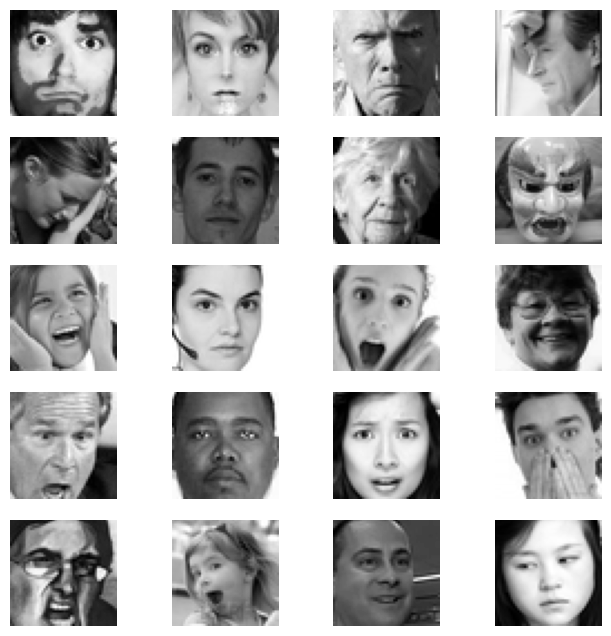

In [56]:
for x,y in train_dataloader:

    fig = plt.figure(figsize=(8, 8))

    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i].permute(1,2,0), cmap='gray')
        plt.axis('off')
    plt.show()
    
    break

### Augmentation Data

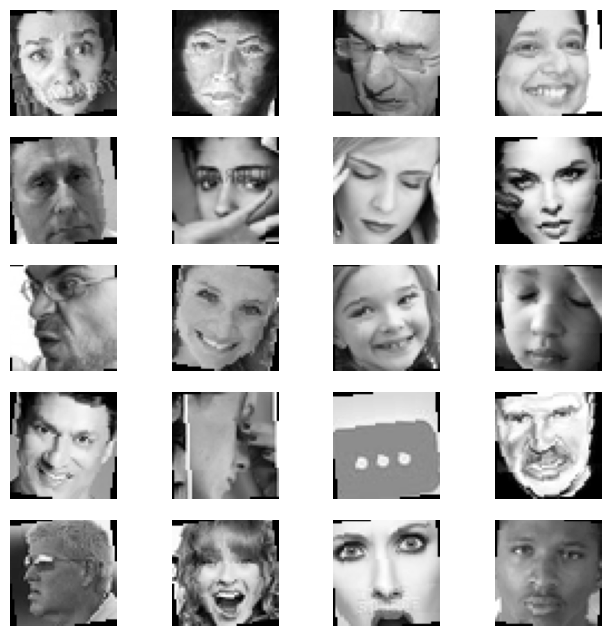

In [38]:
for x,y in train_a_dataloader:

    fig = plt.figure(figsize=(8, 8))

    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i].permute(1,2,0), cmap='gray')
        plt.axis('off')
    plt.show()
    
    break

# Training

## Model Construction

In [281]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        ## Convolutional Layers
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(p=0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(p=0.25)
        
        # Block 3
        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout2d(p=0.25)
        
        # Block 4
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop4 = nn.Dropout2d(p=0.25)
        
        ## Fully-Connected Layers
        self.fc1 = nn.Linear(512*3*3, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.drop5 = nn.Dropout(p=0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.drop6 = nn.Dropout(p=0.25)
        
        self.fc3 = nn.Linear(512, 7)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool4(x)
        x = self.drop4(x)

        x = x.view(-1, 512*3*3)
        x = F.relu(self.fc1(x))
        x = self.bn6(x)
        x = self.drop5(x)

        x = F.relu(self.fc2(x))
        x = self.bn7(x)
        x = self.drop6(x)

        x = F.softmax(self.fc3(x), dim=1)
        return x

Our network consists 4 blocks convolutional blocks and 2 fully-connected layers.<BR>
We tried various architectures and got the best results with the one above.<BR>
The input batch enters the first block with 1 channels and by the end of the convolutional blocks it has 512 channels.<BR>
In between we used batch normalization (to improve performance), pooling (to improve generalization) and dropout (to regulerized the data to avoid overfitting).<BR>
We also used padding and stride to control input shape over the filters and improve performance.
    
Once the data leaves the last convolutional layer, we flatten it and feed it to the first fully-connected layer. Then, we changed it sizes while extracting features until we got 7 neurons.<BR>
Finally, we used softmax to convert the outputs into a probability distribution over the possible classes.

In [408]:
model = CNN()
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = SGD(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [104]:
summary(model, (1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
            Conv2d-3           [-1, 64, 48, 48]          18,496
       BatchNorm2d-4           [-1, 64, 48, 48]             128
         MaxPool2d-5           [-1, 64, 24, 24]               0
         Dropout2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]         204,928
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
        Dropout2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 512, 12, 12]         590,336
      BatchNorm2d-12          [-1, 512, 12, 12]           1,024
        MaxPool2d-13            [-1, 512, 6, 6]               0
        Dropout2d-14            [-1, 51

## Accuracy Function

In [9]:
def get_accuracy(model,data):
    
    acc_list = []

    for idx,batch in enumerate(data):
        
        if idx>5:
            break
      
        x_test,y_test = batch
        # if DEVICE == torch.device('cuda'):
        x_test, y_test = x_test.to(torch.device('cuda')),y_test.to(torch.device('cuda'))
      
        pred = model(x_test)
        pred = pred.argmax(axis=1)
      
        acc = 0
      
        for i in range(len(pred)):
          
            if pred[i] == y_test[i]:
                acc += 1
      
        acc_list.append(acc/len(pred))

    return np.mean(acc_list)

## Train

### Train Function

We will now implement the train function.<BR>
In this function, we will go over the train and validation datasets to train the network and monitor it's performance.<BR>
The training will be done over _DATASET_SIZE_ samples, in _BATCH_SIZE_ chuncks for each epochs. Maximum number of epochs is denoted by _EPOCHS_.

In [165]:
accum_train_loss = []
accum_val_loss = []
accum_val_acc = []

In [400]:
def train(EPOCHS=10, DATASET_SIZE=10000):
    
    for epoch in range(EPOCHS):
        
        if epoch%10:
            shuffle()
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx*BATCH_SIZE > DATASET_SIZE:
                break

            data = data.to('cuda')
            target = target.to('cuda')

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            
            val_loss, val_acc = 0, 0
            for data, target in val_dataloader:
                
                data = data.to('cuda')
                target = target.to('cuda')

                output = model(data)
                val_loss += loss_fn(output, target).item()
                val_acc += (output.argmax(dim=1) == target).sum().item()
                
            val_loss /= len(val_dataloader.dataset)
            val_acc /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
            epoch, loss.item(), val_loss, 100. * val_acc))
        
        accum_train_loss.append(loss.item())
        accum_val_loss.append(val_loss)
        accum_val_acc.append(val_acc)

### Training

In [14]:
train(EPOCHS=100)

Epoch: 0 	Training Loss: 1.857928 	Validation Loss: 0.018615 	Validation Accuracy: 29.97%
Epoch: 1 	Training Loss: 1.806189 	Validation Loss: 0.018029 	Validation Accuracy: 36.42%
Epoch: 2 	Training Loss: 1.796616 	Validation Loss: 0.017569 	Validation Accuracy: 41.31%
Epoch: 3 	Training Loss: 1.693012 	Validation Loss: 0.017736 	Validation Accuracy: 39.88%
Epoch: 4 	Training Loss: 1.717374 	Validation Loss: 0.017278 	Validation Accuracy: 44.27%
Epoch: 5 	Training Loss: 1.719070 	Validation Loss: 0.017154 	Validation Accuracy: 45.82%
Epoch: 6 	Training Loss: 1.706393 	Validation Loss: 0.017020 	Validation Accuracy: 47.25%
Epoch: 7 	Training Loss: 1.708511 	Validation Loss: 0.016968 	Validation Accuracy: 47.37%
Epoch: 8 	Training Loss: 1.608242 	Validation Loss: 0.016680 	Validation Accuracy: 50.56%
Epoch: 9 	Training Loss: 1.688460 	Validation Loss: 0.016661 	Validation Accuracy: 51.20%
Epoch: 10 	Training Loss: 1.599061 	Validation Loss: 0.016659 	Validation Accuracy: 50.78%
Epoch: 11

In [16]:
train(EPOCHS=10)

Epoch: 0 	Training Loss: 1.446685 	Validation Loss: 0.015789 	Validation Accuracy: 59.75%
Epoch: 1 	Training Loss: 1.421652 	Validation Loss: 0.015714 	Validation Accuracy: 60.50%
Epoch: 2 	Training Loss: 1.446289 	Validation Loss: 0.015682 	Validation Accuracy: 60.97%
Epoch: 3 	Training Loss: 1.436079 	Validation Loss: 0.015730 	Validation Accuracy: 60.12%
Epoch: 4 	Training Loss: 1.380850 	Validation Loss: 0.015654 	Validation Accuracy: 61.32%
Epoch: 5 	Training Loss: 1.430805 	Validation Loss: 0.015681 	Validation Accuracy: 60.90%
Epoch: 6 	Training Loss: 1.451635 	Validation Loss: 0.015679 	Validation Accuracy: 60.88%
Epoch: 7 	Training Loss: 1.397034 	Validation Loss: 0.015681 	Validation Accuracy: 60.92%
Epoch: 8 	Training Loss: 1.418909 	Validation Loss: 0.015874 	Validation Accuracy: 59.06%
Epoch: 9 	Training Loss: 1.521171 	Validation Loss: 0.015827 	Validation Accuracy: 59.46%


In [18]:
train(EPOCHS=10)

Epoch: 0 	Training Loss: 1.444648 	Validation Loss: 0.015719 	Validation Accuracy: 60.69%
Epoch: 1 	Training Loss: 1.500468 	Validation Loss: 0.015655 	Validation Accuracy: 61.11%
Epoch: 2 	Training Loss: 1.477641 	Validation Loss: 0.015568 	Validation Accuracy: 62.02%
Epoch: 3 	Training Loss: 1.528955 	Validation Loss: 0.015721 	Validation Accuracy: 60.55%
Epoch: 4 	Training Loss: 1.644361 	Validation Loss: 0.015566 	Validation Accuracy: 62.02%
Epoch: 5 	Training Loss: 1.518644 	Validation Loss: 0.015536 	Validation Accuracy: 62.31%
Epoch: 6 	Training Loss: 1.475953 	Validation Loss: 0.015387 	Validation Accuracy: 63.86%
Epoch: 7 	Training Loss: 1.418744 	Validation Loss: 0.015319 	Validation Accuracy: 64.61%
Epoch: 8 	Training Loss: 1.517430 	Validation Loss: 0.015338 	Validation Accuracy: 64.45%
Epoch: 9 	Training Loss: 1.406323 	Validation Loss: 0.015245 	Validation Accuracy: 65.22%


In [19]:
train(EPOCHS=80)

Epoch: 0 	Training Loss: 1.483774 	Validation Loss: 0.015226 	Validation Accuracy: 65.53%
Epoch: 1 	Training Loss: 1.507368 	Validation Loss: 0.015200 	Validation Accuracy: 65.83%
Epoch: 2 	Training Loss: 1.459620 	Validation Loss: 0.015107 	Validation Accuracy: 66.58%
Epoch: 3 	Training Loss: 1.487653 	Validation Loss: 0.015087 	Validation Accuracy: 66.93%
Epoch: 4 	Training Loss: 1.471697 	Validation Loss: 0.015023 	Validation Accuracy: 67.55%
Epoch: 5 	Training Loss: 1.446462 	Validation Loss: 0.015065 	Validation Accuracy: 67.08%
Epoch: 6 	Training Loss: 1.457179 	Validation Loss: 0.015185 	Validation Accuracy: 66.04%
Epoch: 7 	Training Loss: 1.456908 	Validation Loss: 0.015078 	Validation Accuracy: 67.00%
Epoch: 8 	Training Loss: 1.571295 	Validation Loss: 0.014909 	Validation Accuracy: 68.88%
Epoch: 9 	Training Loss: 1.432767 	Validation Loss: 0.014937 	Validation Accuracy: 68.34%
Epoch: 10 	Training Loss: 1.452727 	Validation Loss: 0.014879 	Validation Accuracy: 68.97%
Epoch: 11

In [21]:
train(EPOCHS=100)

Epoch: 0 	Training Loss: 1.598605 	Validation Loss: 0.013940 	Validation Accuracy: 78.35%
Epoch: 1 	Training Loss: 1.416848 	Validation Loss: 0.013894 	Validation Accuracy: 78.77%
Epoch: 2 	Training Loss: 1.419118 	Validation Loss: 0.013883 	Validation Accuracy: 78.91%
Epoch: 3 	Training Loss: 1.352338 	Validation Loss: 0.013982 	Validation Accuracy: 77.85%
Epoch: 4 	Training Loss: 1.344442 	Validation Loss: 0.013984 	Validation Accuracy: 77.85%
Epoch: 5 	Training Loss: 1.433496 	Validation Loss: 0.013946 	Validation Accuracy: 78.25%
Epoch: 6 	Training Loss: 1.366607 	Validation Loss: 0.013863 	Validation Accuracy: 79.15%
Epoch: 7 	Training Loss: 1.426827 	Validation Loss: 0.013894 	Validation Accuracy: 78.89%
Epoch: 8 	Training Loss: 1.380713 	Validation Loss: 0.013832 	Validation Accuracy: 79.41%
Epoch: 9 	Training Loss: 1.500716 	Validation Loss: 0.013879 	Validation Accuracy: 78.87%
Epoch: 10 	Training Loss: 1.362870 	Validation Loss: 0.013828 	Validation Accuracy: 79.43%
Epoch: 11

In [23]:
train(EPOCHS=100)

Epoch: 0 	Training Loss: 1.350394 	Validation Loss: 0.013342 	Validation Accuracy: 84.45%
Epoch: 1 	Training Loss: 1.336785 	Validation Loss: 0.013308 	Validation Accuracy: 84.62%
Epoch: 2 	Training Loss: 1.355725 	Validation Loss: 0.013306 	Validation Accuracy: 84.64%
Epoch: 3 	Training Loss: 1.331913 	Validation Loss: 0.013299 	Validation Accuracy: 84.66%
Epoch: 4 	Training Loss: 1.315231 	Validation Loss: 0.013261 	Validation Accuracy: 85.14%
Epoch: 5 	Training Loss: 1.405519 	Validation Loss: 0.013271 	Validation Accuracy: 85.06%
Epoch: 6 	Training Loss: 1.385390 	Validation Loss: 0.013275 	Validation Accuracy: 84.97%
Epoch: 7 	Training Loss: 1.391140 	Validation Loss: 0.013300 	Validation Accuracy: 84.73%
Epoch: 8 	Training Loss: 1.358198 	Validation Loss: 0.013282 	Validation Accuracy: 84.90%
Epoch: 9 	Training Loss: 1.323100 	Validation Loss: 0.013260 	Validation Accuracy: 85.13%
Epoch: 10 	Training Loss: 1.361516 	Validation Loss: 0.013276 	Validation Accuracy: 84.97%
Epoch: 11

We trained our network for 400 epochs.<BR>
Please note that we did it in parts to avoid disconnetion (our Colab lesson..)<BR>
We now plot the training and validation loss and the validation accuracy:

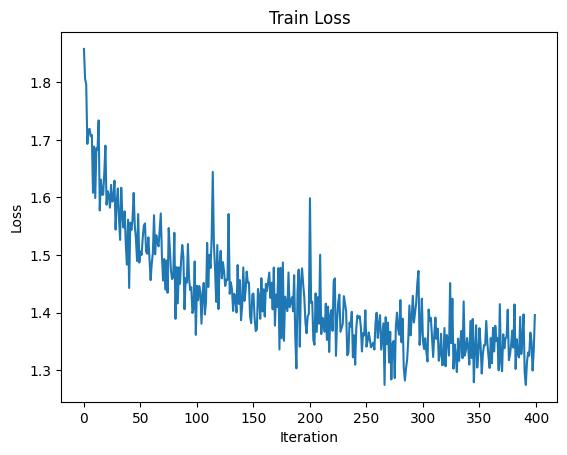

In [389]:
plt.plot(accum_train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

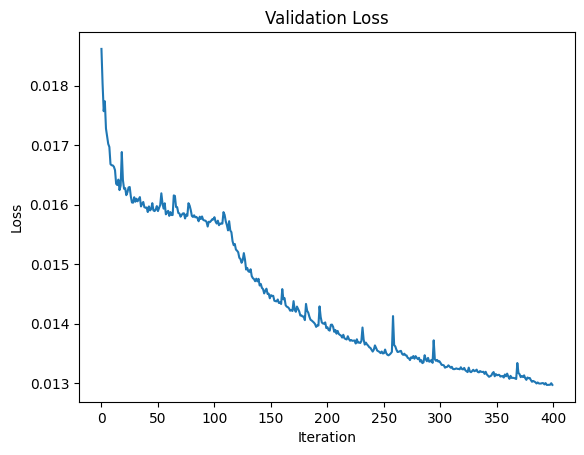

In [392]:
plt.plot(accum_val_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

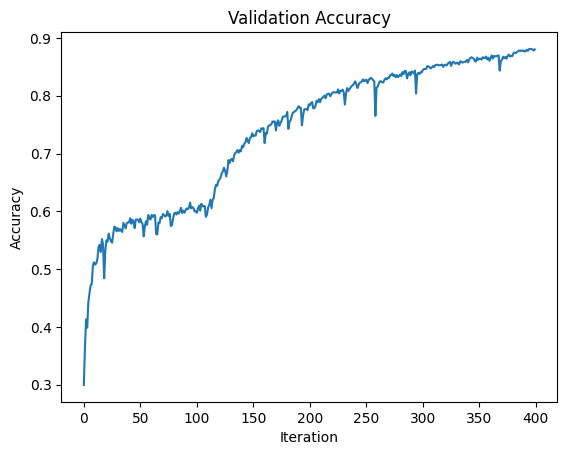

In [391]:
plt.plot(accum_val_acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [218]:
print(f"Train Accuracy: {get_accuracy(model,train_dataloader)*100 :.2f}% \t Val Accuracy: {get_accuracy(model,val_dataloader)*100 :.2f}% \t Test Accuracy: {get_accuracy(model,test_dataloader)*100 :.2f}%")

Train Accuracy: 90.83% 	 Val Accuracy: 89.83% 	 Test Accuracy: 76.35%


We can see that both the training and the validation loss are decreasing nicely, and, more importantly, the validation accuracy rises.<BR>
On the test data, we have 76.35% accuracy.

## Predict New Data

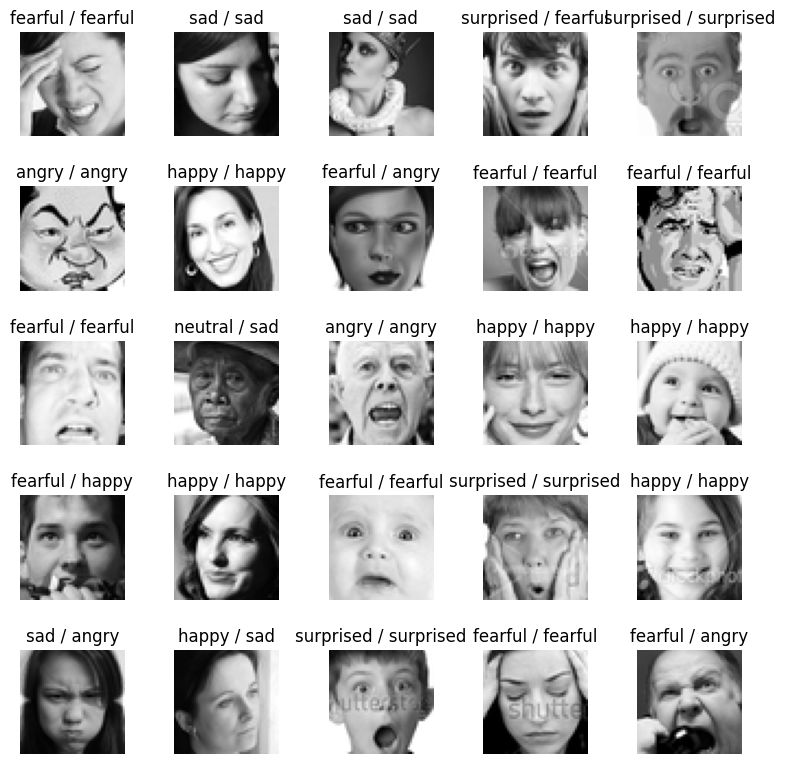

In [163]:
for x,y in test_dataloader:

    fig = plt.figure(figsize=(8, 8))

    columns = 5
    rows = 5
    
    y_pred = torch.argmax(model(x.to('cuda')), axis=1)
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i].permute(1,2,0), cmap='gray')
        plt.title(f"{train_data.classes[y_pred[i].cpu().numpy()]} / {train_data.classes[y[i]]}")
        plt.axis('off')
    
    plt.tight_layout(pad=2)
    plt.show()
    
    break

In the images above we can see our model prediction on a few images from the test dataset.<BR>
The images titles denotes _predicted_ vs. _real_ emotions.<BR>
We can see that most of the images classified correctly (18/25).

### Save Model Results

In [102]:
accum_train_loss = np.array(accum_train_loss)
accum_val_loss = np.array(accum_val_loss)
accum_val_acc = np.array(accum_val_acc)

In [103]:
np.save('Arrays/accum_train_loss.npy', accum_train_loss)
np.save('Arrays/accum_val_loss.npy', accum_val_loss)
np.save('Arrays/accum_val_acc.npy', accum_val_acc)

In [38]:
torch.save(model,'Models/model.pt')

In [127]:
model = torch.load('Models/model.pt')

# Bad Trials

We also used other optimizers such as SGD and change the architecture a lot until we got satisfactory results.<BR>
We ran the training over nights and got a lot of data while tuning the hyperparameters. Of course, we can't show it all here but we showed the main issues.

### High Learning Rate

In [280]:
model = CNN()
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=0.1)

loss_fn = nn.CrossEntropyLoss()

In [283]:
train(EPOCHS=20)

Epoch: 0 	Training Loss: 1.895409 	Validation Loss: 0.019281 	Validation Accuracy: 25.58%
Epoch: 1 	Training Loss: 1.965422 	Validation Loss: 0.019428 	Validation Accuracy: 24.16%
Epoch: 2 	Training Loss: 1.925422 	Validation Loss: 0.019268 	Validation Accuracy: 25.69%
Epoch: 3 	Training Loss: 1.895422 	Validation Loss: 0.019266 	Validation Accuracy: 25.71%
Epoch: 4 	Training Loss: 1.885422 	Validation Loss: 0.019265 	Validation Accuracy: 25.72%
Epoch: 5 	Training Loss: 1.915422 	Validation Loss: 0.019265 	Validation Accuracy: 25.72%
Epoch: 6 	Training Loss: 1.935422 	Validation Loss: 0.019263 	Validation Accuracy: 25.74%
Epoch: 7 	Training Loss: 1.945422 	Validation Loss: 0.019275 	Validation Accuracy: 25.62%
Epoch: 8 	Training Loss: 1.905422 	Validation Loss: 0.019266 	Validation Accuracy: 25.71%
Epoch: 9 	Training Loss: 1.915423 	Validation Loss: 0.019265 	Validation Accuracy: 25.72%
Epoch: 10 	Training Loss: 1.925399 	Validation Loss: 0.019263 	Validation Accuracy: 25.74%
Epoch: 11

In this trial, we used high learning rate (=0.1). We can see that the model fails to converge, i.e. the loss is not decreasing and the accuracy stays the same.<BR>
We kept increasing the learning rate until we got good results (with learning rate = 0.001)

### Too Small Dataset Size

In [405]:
model = CNN()
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [406]:
accum_train_loss = []
accum_val_loss = []
accum_val_acc = []

In [407]:
train(EPOCHS=20, DATASET_SIZE=100)

Epoch: 0 	Training Loss: 1.929950 	Validation Loss: 0.019641 	Validation Accuracy: 17.80%
Epoch: 1 	Training Loss: 1.932229 	Validation Loss: 0.019645 	Validation Accuracy: 17.80%
Epoch: 2 	Training Loss: 1.953862 	Validation Loss: 0.019660 	Validation Accuracy: 17.80%
Epoch: 3 	Training Loss: 1.920042 	Validation Loss: 0.019844 	Validation Accuracy: 17.80%
Epoch: 4 	Training Loss: 1.912269 	Validation Loss: 0.020022 	Validation Accuracy: 17.80%
Epoch: 5 	Training Loss: 1.930864 	Validation Loss: 0.019993 	Validation Accuracy: 17.80%
Epoch: 6 	Training Loss: 1.951942 	Validation Loss: 0.019815 	Validation Accuracy: 17.80%
Epoch: 7 	Training Loss: 1.880570 	Validation Loss: 0.019733 	Validation Accuracy: 17.80%
Epoch: 8 	Training Loss: 1.926124 	Validation Loss: 0.019863 	Validation Accuracy: 17.80%
Epoch: 9 	Training Loss: 1.936889 	Validation Loss: 0.019739 	Validation Accuracy: 17.80%
Epoch: 10 	Training Loss: 1.928356 	Validation Loss: 0.019671 	Validation Accuracy: 17.80%
Epoch: 11

We can see that choosing too small dataset size can lead to divergence.<BR>
We can also see that in the first iterations we got the same value which might indicate overfitting.

# STOA Networks

We now compare our results to state-of-the-art architecture.<BR>
We will deploy and train the following networks:<BR>
    
    1. DenseNet 121
    2. DenseNet 169
    3. DenseNet 201

## DenseNet 121

In [296]:
from torchvision.models import densenet121

In [298]:
model_densenet121 = densenet121(pretrained=True)
model_densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model_densenet121.classifier.in_features
model_densenet121.classifier = nn.Linear(num_ftrs, 7)

model_densenet121 = model_densenet121.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet121.parameters(), lr=0.001)

In [299]:
accum_train_loss = []
accum_val_loss = []
accum_val_acc = []

In [300]:
train(model_densenet121, EPOCHS=50)

Epoch: 0 	Training Loss: 1.614549 	Validation Loss: 0.019062 	Validation Accuracy: 37.67%
Epoch: 1 	Training Loss: 1.582379 	Validation Loss: 0.039417 	Validation Accuracy: 41.17%
Epoch: 2 	Training Loss: 1.392664 	Validation Loss: 0.015869 	Validation Accuracy: 41.03%
Epoch: 3 	Training Loss: 1.442092 	Validation Loss: 0.013705 	Validation Accuracy: 47.04%
Epoch: 4 	Training Loss: 1.373899 	Validation Loss: 0.012794 	Validation Accuracy: 51.06%
Epoch: 5 	Training Loss: 1.486814 	Validation Loss: 0.017808 	Validation Accuracy: 42.91%
Epoch: 6 	Training Loss: 1.311968 	Validation Loss: 0.012576 	Validation Accuracy: 52.86%
Epoch: 7 	Training Loss: 1.193412 	Validation Loss: 0.012423 	Validation Accuracy: 53.36%
Epoch: 8 	Training Loss: 1.368113 	Validation Loss: 0.016780 	Validation Accuracy: 46.33%
Epoch: 9 	Training Loss: 1.072574 	Validation Loss: 0.013436 	Validation Accuracy: 53.73%
Epoch: 10 	Training Loss: 1.245017 	Validation Loss: 0.012643 	Validation Accuracy: 52.42%
Epoch: 11

In [301]:
densenet121_train_loss = np.array(accum_train_loss)
densenet121_val_loss = np.array(accum_val_loss)
densenet121_val_acc = np.array(accum_val_acc)

In [302]:
np.save('Arrays/densenet121_accum_train_loss.npy', densenet121_train_loss)
np.save('Arrays/densenet121_accum_val_loss.npy', densenet121_val_loss)
np.save('Arrays/densenet121_accum_val_acc.npy', densenet121_val_acc)

In [361]:
torch.save(model_densenet121,'Models/model_densenet121.pt')

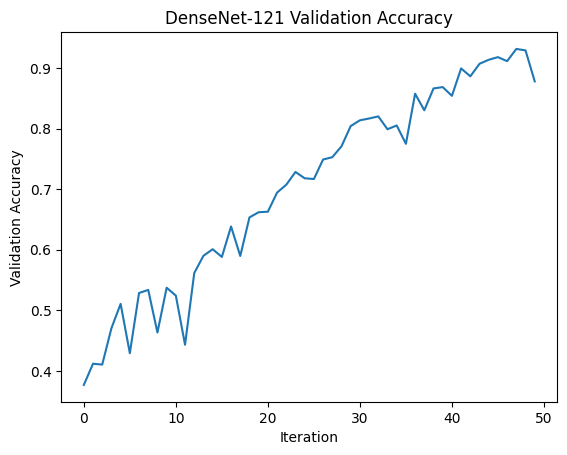

In [380]:
plt.plot(densenet121_val_acc)
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('DenseNet-121 Validation Accuracy')
plt.show()

In [415]:
print(f"Train Accuracy: {get_accuracy(model_densenet121,train_dataloader)*100 :.2f}% \t Val Accuracy: {get_accuracy(model_densenet121,val_dataloader)*100 :.2f}% \t Test Accuracy: {get_accuracy(model_densenet121,test_dataloader)*100 :.2f}%")

Train Accuracy: 87.17% 	 Val Accuracy: 88.17% 	 Test Accuracy: 63.17%


## DenseNet 169

In [335]:
from torchvision.models import densenet169

In [337]:
model_densenet169 = densenet169(pretrained=True)
model_densenet169.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model_densenet169.classifier.in_features
model_densenet169.classifier = nn.Linear(num_ftrs, 7)

model_densenet169 = model_densenet169.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet169.parameters(), lr=0.001)

In [338]:
accum_train_loss = []
accum_val_loss = []
accum_val_acc = []

In [339]:
train(model_densenet169, EPOCHS=50)

Epoch: 0 	Training Loss: 1.735945 	Validation Loss: 0.025388 	Validation Accuracy: 28.51%
Epoch: 1 	Training Loss: 1.640091 	Validation Loss: 0.015660 	Validation Accuracy: 39.18%
Epoch: 2 	Training Loss: 1.565557 	Validation Loss: 0.025241 	Validation Accuracy: 31.09%
Epoch: 3 	Training Loss: 1.500902 	Validation Loss: 0.018781 	Validation Accuracy: 36.80%
Epoch: 4 	Training Loss: 1.442754 	Validation Loss: 0.014278 	Validation Accuracy: 44.67%
Epoch: 5 	Training Loss: 1.483766 	Validation Loss: 0.015309 	Validation Accuracy: 40.89%
Epoch: 6 	Training Loss: 1.379521 	Validation Loss: 0.013282 	Validation Accuracy: 48.97%
Epoch: 7 	Training Loss: 1.395307 	Validation Loss: 0.013943 	Validation Accuracy: 47.20%
Epoch: 8 	Training Loss: 1.371977 	Validation Loss: 0.014732 	Validation Accuracy: 42.41%
Epoch: 9 	Training Loss: 1.367396 	Validation Loss: 0.013640 	Validation Accuracy: 48.14%
Epoch: 10 	Training Loss: 1.225869 	Validation Loss: 0.014798 	Validation Accuracy: 44.62%
Epoch: 11

In [340]:
densenet169_train_loss = np.array(accum_train_loss)
densenet169_val_loss = np.array(accum_val_loss)
densenet169_val_acc = np.array(accum_val_acc)

In [341]:
np.save('Arrays/densenet169_accum_train_loss.npy', densenet169_train_loss)
np.save('Arrays/densenet169_accum_val_loss.npy', densenet169_val_loss)
np.save('Arrays/densenet169_accum_val_acc.npy', densenet169_val_acc)

In [360]:
torch.save(model_densenet169,'Models/model_densenet169.pt')

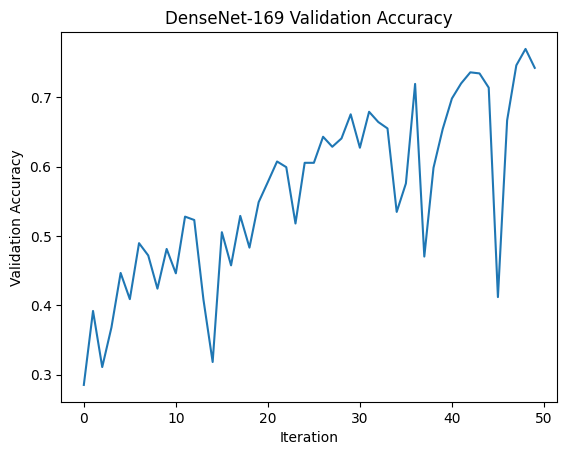

In [379]:
plt.plot(densenet169_val_acc)
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('DenseNet-169 Validation Accuracy')
plt.show()

In [413]:
print(f"Train Accuracy: {get_accuracy(model_densenet169,train_dataloader)*100 :.2f}% \t Val Accuracy: {get_accuracy(model_densenet169,val_dataloader)*100 :.2f}% \t Test Accuracy: {get_accuracy(model_densenet169,test_dataloader)*100 :.2f}%")

Train Accuracy: 76.50% 	 Val Accuracy: 76.00% 	 Test Accuracy: 60.17%


## DenseNet 201

In [344]:
from torchvision.models import densenet201

In [345]:
model_densenet201 = densenet201(pretrained=True)
model_densenet201.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model_densenet201.classifier.in_features
model_densenet201.classifier = nn.Linear(num_ftrs, 7)

model_densenet201 = model_densenet201.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet201.parameters(), lr=0.001)

C:\Users\lior1\anaconda3\envs\Lior\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\lior1/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|█████████████████████████████████████████████████████████████████████████████| 77.4M/77.4M [00:02<00:00, 27.2MB/s]


In [346]:
accum_train_loss = []
accum_val_loss = []
accum_val_acc = []

In [347]:
train(model_densenet201, EPOCHS=50)

Epoch: 0 	Training Loss: 1.646800 	Validation Loss: 0.016066 	Validation Accuracy: 37.16%
Epoch: 1 	Training Loss: 1.488147 	Validation Loss: 0.022253 	Validation Accuracy: 38.37%
Epoch: 2 	Training Loss: 1.504138 	Validation Loss: 0.013680 	Validation Accuracy: 48.43%
Epoch: 3 	Training Loss: 1.391930 	Validation Loss: 0.015865 	Validation Accuracy: 45.19%
Epoch: 4 	Training Loss: 1.374612 	Validation Loss: 0.013886 	Validation Accuracy: 49.09%
Epoch: 5 	Training Loss: 1.433075 	Validation Loss: 0.023768 	Validation Accuracy: 37.70%
Epoch: 6 	Training Loss: 1.300830 	Validation Loss: 0.013512 	Validation Accuracy: 49.93%
Epoch: 7 	Training Loss: 1.335832 	Validation Loss: 0.011983 	Validation Accuracy: 55.68%
Epoch: 8 	Training Loss: 1.424116 	Validation Loss: 0.015075 	Validation Accuracy: 43.61%
Epoch: 9 	Training Loss: 1.426001 	Validation Loss: 0.013125 	Validation Accuracy: 51.31%
Epoch: 10 	Training Loss: 1.165346 	Validation Loss: 0.011473 	Validation Accuracy: 58.19%
Epoch: 11

In [348]:
densenet201_train_loss = np.array(accum_train_loss)
densenet201_val_loss = np.array(accum_val_loss)
densenet201_val_acc = np.array(accum_val_acc)

In [349]:
np.save('Arrays/densenet201_accum_train_loss.npy', densenet201_train_loss)
np.save('Arrays/densenet201_accum_val_loss.npy', densenet201_val_loss)
np.save('Arrays/densenet201_accum_val_acc.npy', densenet201_val_acc)

In [359]:
torch.save(model_densenet201,'Models/model_densenet201.pt')

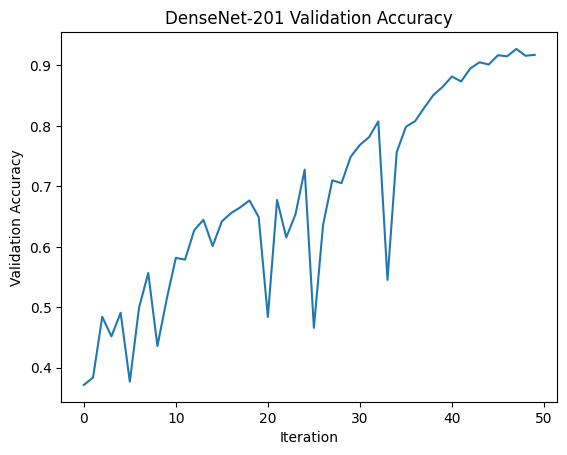

In [376]:
plt.plot(densenet201_val_acc)
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('DenseNet-201 Validation Accuracy')
plt.show()

In [411]:
print(f"Train Accuracy: {get_accuracy(model_densenet201,train_dataloader)*100 :.2f}% \t Val Accuracy: {get_accuracy(model_densenet201,val_dataloader)*100 :.2f}% \t Test Accuracy: {get_accuracy(model_densenet201,test_dataloader)*100 :.2f}%")

Train Accuracy: 92.67% 	 Val Accuracy: 92.00% 	 Test Accuracy: 60.17%


## STOA Compare

[]

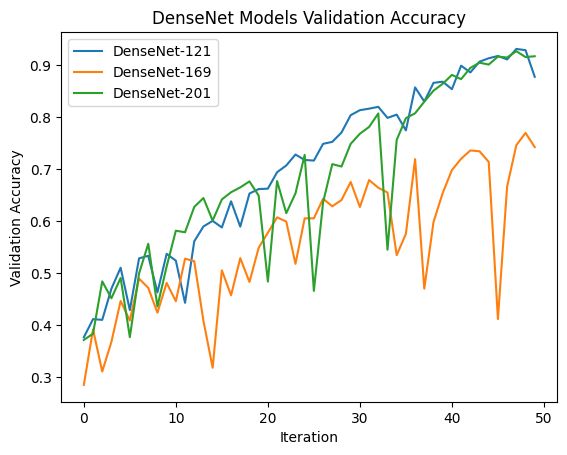

In [378]:
plt.plot(densenet121_val_acc, label='DenseNet-121')
plt.plot(densenet169_val_acc, label='DenseNet-169')
plt.plot(densenet201_val_acc, label='DenseNet-201')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('DenseNet Models Validation Accuracy')
plt.legend()
plt.plot()

As we can see, we got high accuracies using the DenseNet architectures after (only) 50 iterations.<BR>
We got the same performance with our model, but only after 400 iterations.<BR>

# Summary

Our objective in this project was to detect emotions from face expression.<BR>
We used CNNs as learned in class and construct a model that was able to complete the task with good results, especially comparing to the benchmarks.<BR>
By building the network from scratch, we encountered a lot of common issues such as overfitting, in-generalization and more. We worked a lot (and also bumped our heads in the wall a lot), but eventually we manage to solve them all.<BR>
During the project we learned a lot and gain parctical experience and theoretical knowledge which is priceless.

We would like to take this opportunity to thank you for guiding us thorugh this project and course.